In [95]:
#Imports
from flask import Flask, request
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os
from PIL import Image
import base64

<h3>Loading the model :<h3/>

In [97]:
def load_model(nb_features,loss, optimizer='adam', metrics=['accuracy']):
    resnet_features = ResNet50(include_top=False, input_shape=(112, 112, 3), pooling='avg')
    for layer in resnet_features.layers:
        layer.trainable = False
    model = Sequential([resnet_features,Dense(nb_features),Activation('sigmoid') ])
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)  
    model = keras.models.load_model(glob.glob('./model_20_epochs.h5')[0])
    return model

model = load_model(40,'binary_crossentropy')

<h3>Preparing the testing dataset :<h3/>

In [98]:
DATASET_PATH = './input/list_attr_celeba.csv'
IMGS_PATH = './input/img_align_celeba/img_align_celeba'

attr_df = pd.read_csv(DATASET_PATH)

attr_np = np.array(attr_df) #shape (202599,41)

# Making the dataset onehot
result = np.copy(attr_np)
result[result == -1] = 0
celeb_dataset = result

#splitting dataset
cut_size = int(0.2 * len(celeb_dataset))
cut_indices = np.random.randint(0, len(celeb_dataset), size=(cut_size, ))
    
other = celeb_dataset[cut_indices]
main = np.delete(celeb_dataset, cut_indices, axis=0)

train_np, test_np = split_dataset(celeb_dataset, 0.1)

def load_and_process_image(name, attrs):
    full_path = IMGS_PATH + os.sep + name
    image = tf.io.read_file(full_path)
    image = tf.io.decode_jpeg(contents=image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.divide(image, 255.)
    image = tf.image.resize(image, size=(112, 112))

    return image, attrs

img_path = test_np[:, 0]
img_attrs = test_np[:, 1:]
    
path_ds = tf.data.Dataset.from_tensor_slices(img_path)
attrs_ds = tf.data.Dataset.from_tensor_slices(img_attrs.astype(np.int16))
    
test_ds = tf.data.Dataset.zip((path_ds, attrs_ds))

test_ds = test_ds.map(load_and_process_image)

test_ds = test_ds.shuffle(256)
test_ds = test_ds.batch(64)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)



--------------------------------------
TOTAL:	202599 
FIRST:	183324 
SECOND:	20259
--------------------------------------


<h3>Testing the model :<h3/>

In [77]:
thershold = 0.4
#--------
# A list to stock the accuracy for each label

Acc = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for test_images, test_labels in test_ds : 

    # Predicting Labels
    pred_labels = model.predict(test_images)
    
    # Changing Predicted labels to One-Hot
    pred_labels[pred_labels >= thershold] = 1
    pred_labels[pred_labels < thershold] = 0
    
    for i in range(len(test_labels)) :
        for j in range (40):
            if (pred_labels[i][j] == test_labels[i][j]):
                Acc[j] += 1

2/2 [==============================] - 1s 721ms/step


2/2 [==============================] - 1s 123ms/step


In [6]:
Acc1 = [round ((x / 20259),2) for x in Acc]

NameError: name 'Acc' is not defined

In [120]:
glob_acc = 0
for i in Acc1 :
    glob_acc += i
    
glob_acc /= 40

In [90]:
glob_acc

0.8396984056468728

In [2]:
features = ['5_o_Clock_Shadow','Arched_Eyebrows','Attractive','Bags_Under_Eyes','Bald','Bangs',
                'Big_Lips','Big_Nose','Black_Hair','Blond_Hair','Blurry','Brown_Hair','Bushy_Eyebrows',
                'Chubby','Double_Chin','Eyeglasses','Goatee','Gray_Hair','Heavy_Makeup','High_Cheekbones',
                'Male','Mouth_Slightly_Open','Mustache','Narrow_Eyes','No_Beard','Oval_Face','Pale_Skin',
                'Pointy_Nose','Receding_Hairline','Rosy_Cheeks','Sideburns','Smiling','Straight_Hair',
                'Wavy_Hair','Wearing_Earrings','Wearing_Hat','Wearing_Lipstick','Wearing_Necklace',
                'Wearing_Necktie','Young']

In [3]:
acc_dic = {i:0 for i in features}
index = 0
for i in acc_dic :
    acc_dic[i] = Acc1[index]
    index += 1

NameError: name 'Acc1' is not defined

In [4]:
acc_dic

{'5_o_Clock_Shadow': 0,
 'Arched_Eyebrows': 0,
 'Attractive': 0,
 'Bags_Under_Eyes': 0,
 'Bald': 0,
 'Bangs': 0,
 'Big_Lips': 0,
 'Big_Nose': 0,
 'Black_Hair': 0,
 'Blond_Hair': 0,
 'Blurry': 0,
 'Brown_Hair': 0,
 'Bushy_Eyebrows': 0,
 'Chubby': 0,
 'Double_Chin': 0,
 'Eyeglasses': 0,
 'Goatee': 0,
 'Gray_Hair': 0,
 'Heavy_Makeup': 0,
 'High_Cheekbones': 0,
 'Male': 0,
 'Mouth_Slightly_Open': 0,
 'Mustache': 0,
 'Narrow_Eyes': 0,
 'No_Beard': 0,
 'Oval_Face': 0,
 'Pale_Skin': 0,
 'Pointy_Nose': 0,
 'Receding_Hairline': 0,
 'Rosy_Cheeks': 0,
 'Sideburns': 0,
 'Smiling': 0,
 'Straight_Hair': 0,
 'Wavy_Hair': 0,
 'Wearing_Earrings': 0,
 'Wearing_Hat': 0,
 'Wearing_Lipstick': 0,
 'Wearing_Necklace': 0,
 'Wearing_Necktie': 0,
 'Young': 0}

NameError: name 'Acc1' is not defined

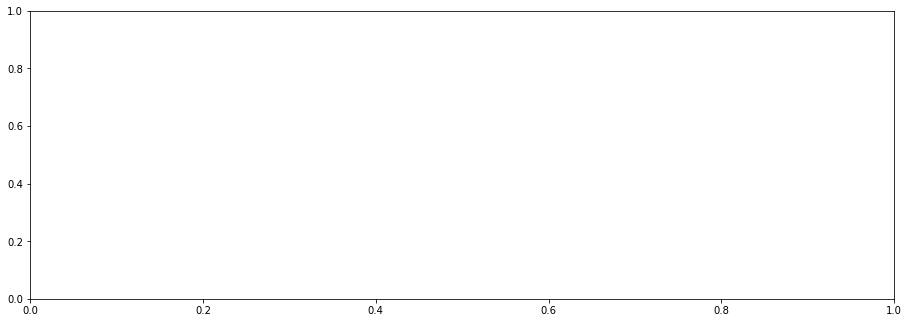

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.bar(features,Acc1,color=['black', 'red', 'green', 'blue', 'cyan'])
plt.xticks(rotation=90)

plt.show()